(15001, 10)
[1]
(13000, 1053)


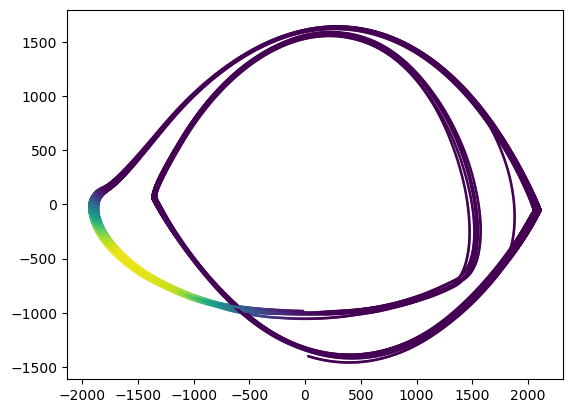

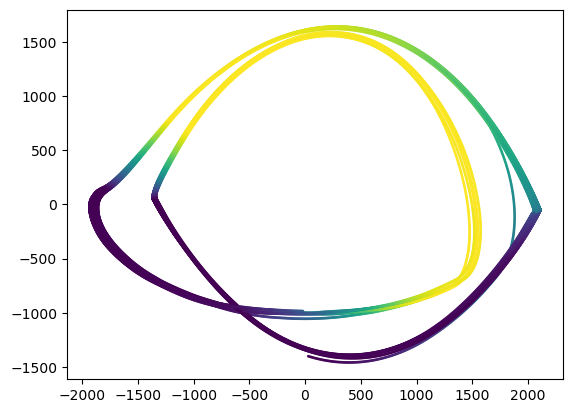

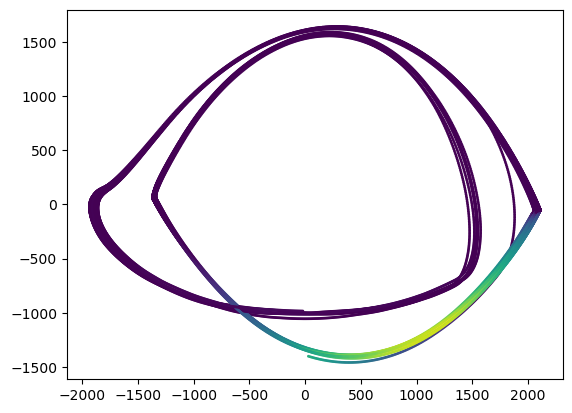

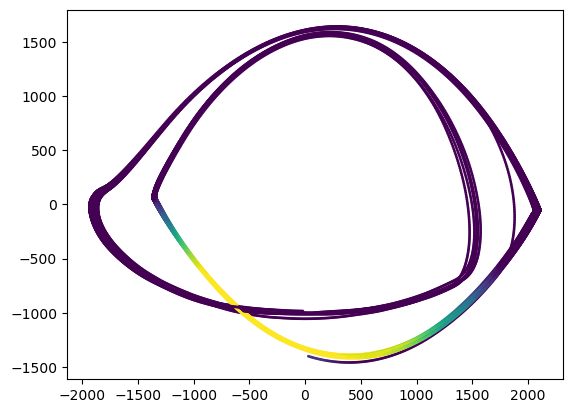

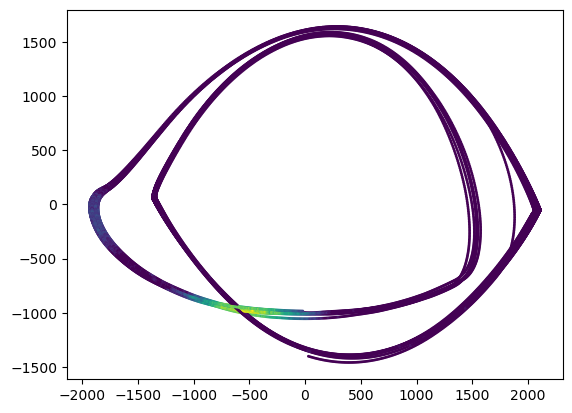

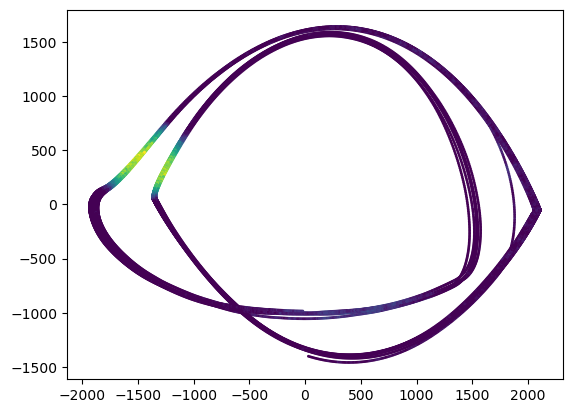

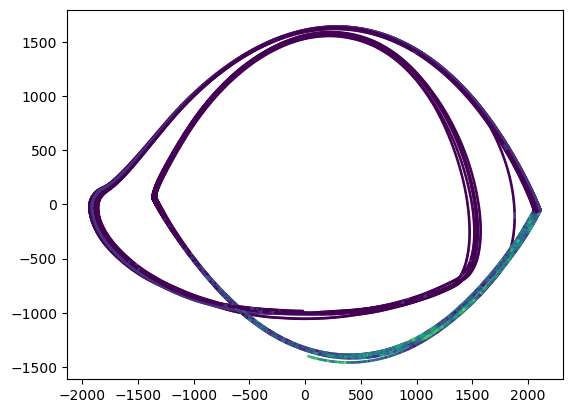

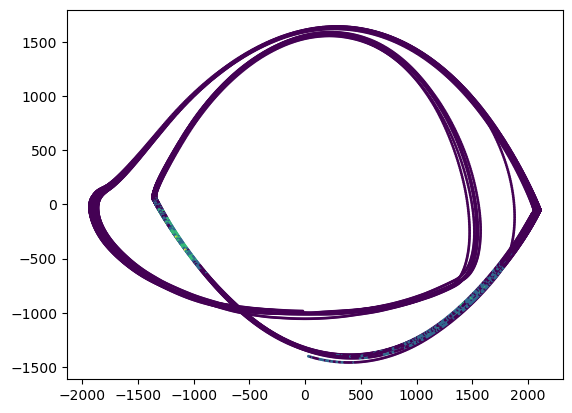

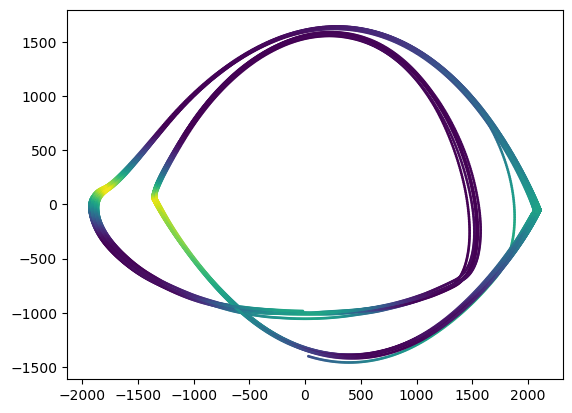

In [2]:
import scipy
import numpy as np
import sklearn
import sklearn.decomposition
from matplotlib import pyplot as plt
data_file = open("MI_timesteps.txt")
data_file.readline()
dataL = [[int(y) for y in x.strip().split(" ")] for x in data_file.readlines()]
data_full = np.array(dataL)
print(data_full.shape)
selection = np.arange(1000,14000)
data = data_full[selection]
print(np.unique(data[1:,0]-data[:-1,0]))
tde = np.stack([data_full[i:i+351] for i in range(data.shape[0])])
tde1 = tde[:,:,2:5].reshape(tde.shape[0],-1)
print(tde1.shape)
pca = sklearn.decomposition.PCA(2)
x_pca = pca.fit_transform(tde1)
for i in range(1,10):
    plt.scatter(*x_pca.T, s=1, c=data[:, i])
    plt.show()

<Figure size 640x480 with 0 Axes>

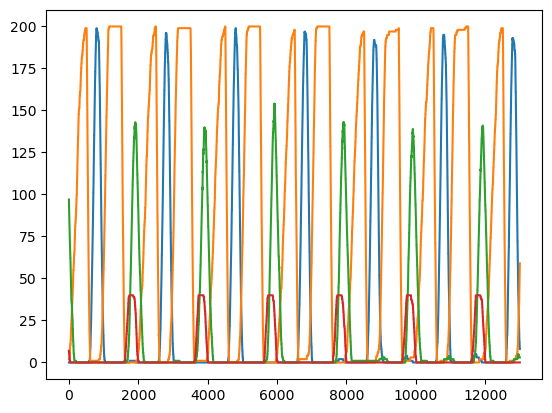

<Figure size 640x480 with 0 Axes>

In [2]:
plt.plot(np.arange(data.shape[0]),data[:,1])
plt.plot(np.arange(data.shape[0]),data[:,2])
plt.plot(np.arange(data.shape[0]),data[:,3])
plt.plot(np.arange(data.shape[0]),data[:,4])
plt.figure()

[5999 5998 5997 5996 4000 3999 5995 4001 5994 3998 5993 4002 3997 5992
 2000 5991 4003]
2000


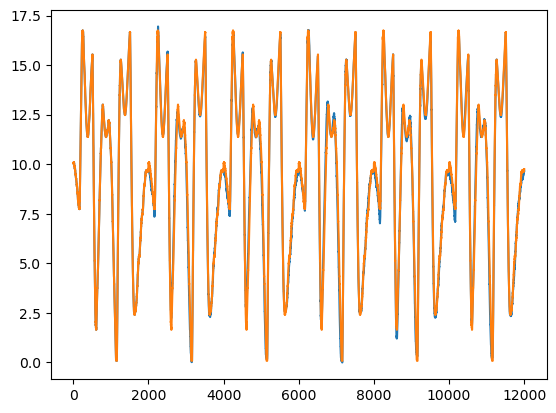

In [23]:
delta_time = (data[1:, 0] - data[:-1, 0])
arclen_derivative = np.expand_dims(np.linalg.norm(x_pca[1:] - x_pca[:-1], axis=1) / delta_time, 1)[1000:]
arclen = np.cumsum(arclen_derivative,0)
starting_point = x_pca[0]
x_pca_train = x_pca[:arclen.shape[0]]
dists = np.linalg.norm(x_pca_train - starting_point, axis=1)
order = np.lexsort(np.expand_dims(dists, 0), axis=0)
best_loss = np.infty
best_iter_length = 0

def f(arclen_derivative, next_iter_start):
    return np.concatenate(
        [arclen_derivative[:next_iter_start] for _ in range(1 + arclen_derivative.shape[0] // next_iter_start)], 0)[
           :arclen_derivative.shape[0]]

losses = []
iter_lengths = []
for iter_length in range(1, 6000):
    pred = f(arclen_derivative, iter_length)
    loss = np.average(np.abs(pred - arclen_derivative))
    losses.append(loss)
    iter_lengths.append(iter_length)
losses = np.array(losses)
iter_lengths = np.array(iter_lengths)
best_inds = np.argsort(losses)[:17]
earliest_best_ind = np.min(best_inds)
print(iter_lengths[best_inds])
print(iter_lengths[earliest_best_ind])
plt.plot(arclen_derivative)
plt.plot(f(arclen_derivative, iter_lengths[earliest_best_ind]))

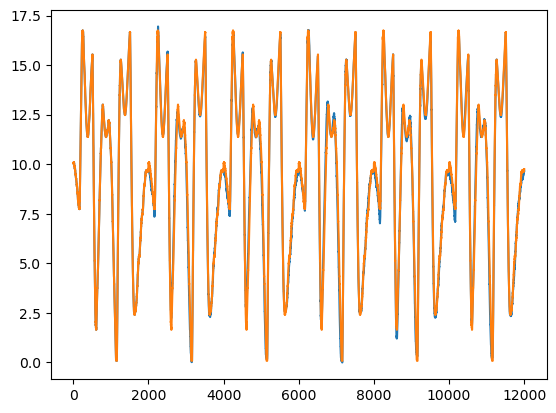

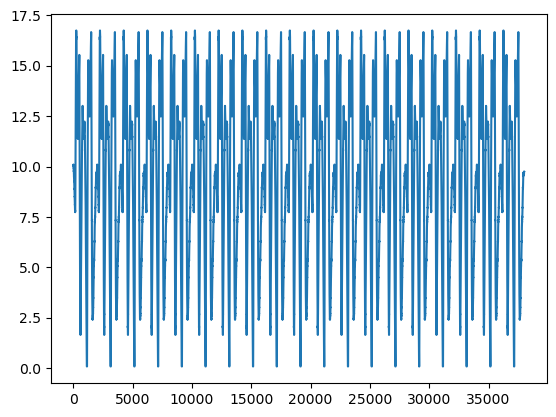

In [18]:
def f(arclen_derivative, next_iter_start, time):
    return np.concatenate(
        [arclen_derivative[:next_iter_start] for _ in range(1 + time // next_iter_start)], 0)[
           :time]

plt.plot(arclen_derivative)
plt.plot(f(arclen_derivative, 2000, arclen_derivative.shape[0]))
plt.show()
preds_arclen_derivative = f(arclen_derivative, 2000, 2000*19)
plt.plot(preds_arclen_derivative)

best_eps 3601
best_loss 4508154677.835294
best_L 2


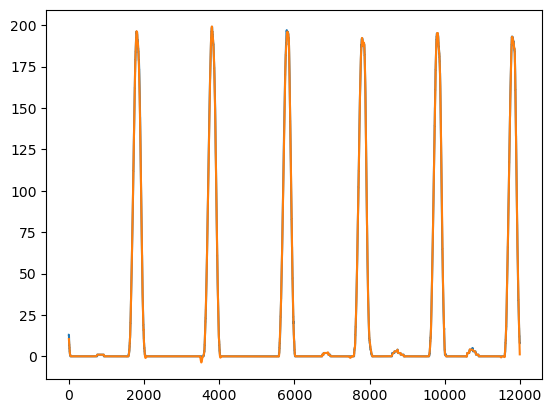

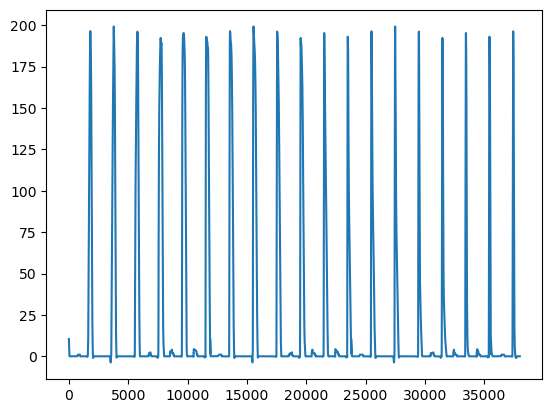

In [19]:
def rbfeval(data,rbf):
    if len(data.shape) < 2:
        data = np.expand_dims(data,1)
    return rbf(data)
area1_rbf_data = arclen
area1_rbf_labels = data[1000:, 1]
subsamplep = np.arange(area1_rbf_data.shape[0])
np.random.shuffle(subsamplep)
train_inds = subsamplep[:1000]
test_inds = subsamplep[1000:2000]
best_loss = np.infty
best_rbf = None
best_eps = None
best_L = None
worst = False
for L in range(2,5):
    for eps in range(1,5000,200):
        td = area1_rbf_data[train_inds]
        tl = area1_rbf_labels[train_inds]
        rbf = scipy.interpolate.RBFInterpolator(td, tl, epsilon=eps, degree = L)
        loss = np.average(np.square(area1_rbf_data[test_inds] - rbf(area1_rbf_data[test_inds])))
        if worst:
            loss = -loss
        if loss < best_loss:
            best_L = L
            best_rbf = rbf
            best_eps = eps
            best_loss = loss
print("best_eps", best_eps)
print("best_loss", best_loss)
print("best_L", best_L)
plt.plot(area1_rbf_labels)
plt.plot(best_rbf(area1_rbf_data))
plt.show()
plt.plot(rbfeval(np.cumsum(preds_arclen_derivative)%arclen[-1],best_rbf))